# Gaussian Process Input Error Algorithms

In [56]:
import sys
sys.path.insert(0, '/Users/eman/Documents/code_projects/gp_error')
sys.path.insert(0, '/home/emmanuel/code/kernellib')
sys.path.insert(0, '/home/emmanuel/projects/gp_error')

from gp_error.gaussianprocess import GPRegressor, ErrorHermiteGauss
from sklearn.gaussian_process.kernels import (ConstantKernel as C, RBF, WhiteKernel)
from gp_extras.kernels import HeteroscedasticKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import interpolate
from scipy.stats import multivariate_normal
import pandas as pd
# from gp_error.gaussianprocess import GPUncertainty
from gp_error.data import example_1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
fig_save = "/home/emmanuel/projects/gp_error/figures/2d_example/"

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Sample Data

In [57]:
def example_2d(x1_cov=0.1, x2_cov=0.3):
    seed = 123
    rng = np.random.RandomState(seed=seed)

    # sample data parameters
    x1_grid, x2_grid = 20, 20
    n_train = 50

    # Y Noise Covariance
    sigma_y = 0.05

    # X noise covariances


    x_cov = np.array([x1_cov, x2_cov])

    x1_min, x1_max = -10, 10
    x2_min, x2_max = -10, 10

    x1 = np.linspace(x1_min, x1_max, x1_grid)
    x2 = np.linspace(x2_min, x2_max, x2_grid)

    X1, X2 = np.meshgrid(x1, x2)

    X1, X2 = X1.flatten(), X2.flatten()

    X = np.vstack((X1, X2)).T



    x1_scale = 0.075
    x2_scale = 0.5
    y_scale = 0.5

    # real function
    f = lambda x: np.exp(x1_scale * x[:, 1]) + np.cos(x2_scale * x[:, 0])  
    # f = lambda x: x1_scale * x[:, 1] + np.cos(x2_scale * x[:, 0]) 
    # f = lambda x: np.sin(1.0 * np.pi / 1.6 * np.cos(y_scale * x[:, 0])) + x1_scale * x[:, 1]

    # f = lambda x: np.cos(y_scale * x[:, 0]) + x1_scale * x[:, 1]


    Y = f(X)

    # Add Noise

    x_train = np.vstack((X1 + x1_cov * rng.randn(X1.shape[0]),
                         X2 + x2_cov * rng.randn(X2.shape[0]))).T
    #X + x_cov * rng.randn(X.shape[0], X.shape[1])
    y_train = Y + sigma_y * rng.randn(Y.shape[0])

    y_train = y_train[:, np.newaxis]

    # -----------------
    # Testing Data
    # -----------------
    seed = 0
    rng = np.random.RandomState(seed=seed)

    xt1_grid, xt2_grid = 20, 20
    xt1_min, xt1_max = -8, 8
    xt2_min, xt2_max = -8, 8

    xt1 = np.linspace(xt1_min, xt1_max, xt1_grid)
    xt2 = np.linspace(xt2_min, xt2_max, xt2_grid)

    Xt1, Xt2 = np.meshgrid(xt1, xt2)

    Xt1, Xt2 = Xt1.flatten(), Xt2.flatten()

    Xt = np.vstack((Xt1, Xt2)).T

    y_test = f(Xt)

    y_test = y_test[:, np.newaxis]

    x_test = np.vstack((Xt1 + x1_cov * rng.randn(Xt1.shape[0]),
                        Xt2 + x2_cov * rng.randn(Xt2.shape[0]))).T


    # --------------------
    # Plotting Data
    # --------------------
    xp1_grid, xp2_grid = 20, 20
    xp1_min, xp1_max = -8, 8
    xp2_min, xp2_max = -8, 8

    xp1 = np.linspace(xp1_min, xp1_max, xp1_grid)
    xp2 = np.linspace(xp2_min, xp2_max, xp2_grid)

    Xp1, Xp2 = np.meshgrid(xp1, xp2)

    Xp1, Xp2 = Xp1.flatten(), Xp2.flatten()

    x_plot = np.vstack((Xp1, Xp2)).T
    y_plot = f(x_plot)
    
    X = {
        'train': x_train,
        'test': x_test,
        'plot': x_plot 
    }
    y = {
        'train': y_train,
        'test': y_test,
        'plot': y_plot
    }
    error_params = {
        'x': x_cov,
        'y': sigma_y,
        'f': f
    }
    return X, y, error_params

In [58]:
X, y, error_params = example_2d()
x_error = error_params['x']
print(x_error)

[0.1 0.3]


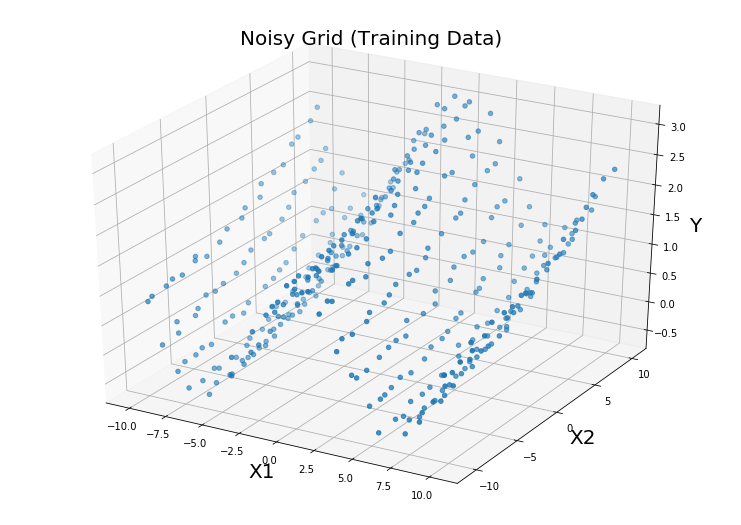

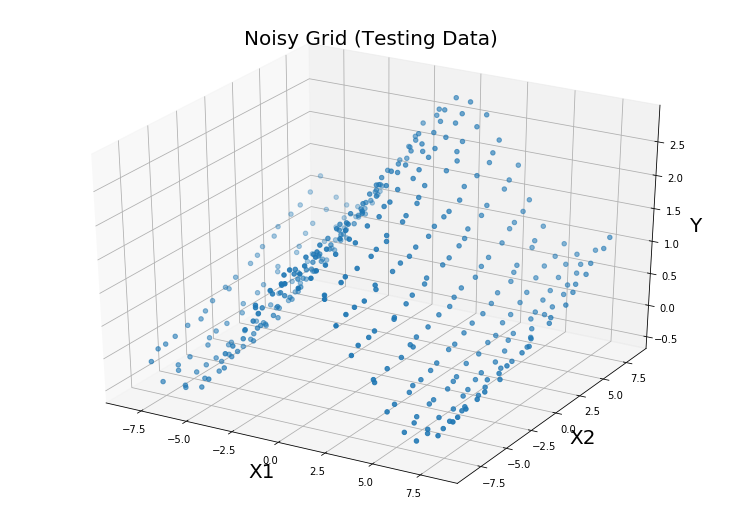

In [59]:
# ---------------------
# NOISY TRAINING DATA
# ---------------------


fig, ax = plt.subplots(figsize=(10, 7))

ax = axes3d.Axes3D(fig)

ax.scatter3D(X['train'][:,0], X['train'][:,1], y['train'])

ax.set_title('Noisy Grid (Training Data)', fontsize=20)
ax.set_xlabel('X1', fontsize=20)
ax.set_ylabel('X2', fontsize=20)
ax.set_zlabel('Y', fontsize=20)

plt.show()

# save_name = 'training_data.png'

# fig.savefig(figure_location + save_name, bbox_inhces='tight')


# ---------------------
# NOISY TEST DATA
# ---------------------



fig, ax = plt.subplots(figsize=(10, 7))

ax = axes3d.Axes3D(fig)

ax.scatter3D(X['test'][:,0], X['test'][:, 1], y['test'])

ax.set_title('Noisy Grid (Testing Data)', fontsize=20)
ax.set_xlabel('X1', fontsize=20)
ax.set_ylabel('X2', fontsize=20)
ax.set_zlabel('Y', fontsize=20)

plt.show()

# save_name = 'test_data.png'

# fig.savefig(figure_location + save_name, bbox_inhces='tight')

In [60]:
def plot_gp_pred(predictions, X, title=None, save_name=None):
    
    fig, ax = plt.subplots(figsize=(10, 7))

    ax = axes3d.Axes3D(fig)
    
    ax.scatter3D(X['train'][:,0], X['train'][:,1], y['train'], color='red')    
    ax.plot_trisurf(X['plot'][:, 0], X['plot'][:, 1], predictions.squeeze(), cmap=cm.autumn, linewidth=0.2)


    ax.set_xlabel('X1', fontsize=20)
    ax.set_ylabel('X2', fontsize=20)
    ax.set_zlabel('Y', fontsize=20)
    
    if save_name is not None:
        fig.savefig(fig_save + save_name + '.png', bbox_inhces='tight',
                    dpi=100, transparent=True, frameon=None)
    
    
    return None

def plot_gp_var(variances, X, title=None, save_name=None):
    
    fig, ax = plt.subplots(figsize=(10, 7))

    ax = axes3d.Axes3D(fig)
    
    ax.plot_trisurf(X['plot'][:, 0], X['plot'][:, 1], variances.squeeze(), cmap=cm.winter, linewidth=0.2)


    ax.set_xlabel('X1', fontsize=20)
    ax.set_ylabel('X2', fontsize=20)
    ax.set_zlabel('Y', fontsize=20)
    
    if save_name is not None:
        fig.savefig(fig_save + save_name + '.png', bbox_inhces='tight',
                    dpi=100, transparent=True, frameon=None)
    
    
    return None

## Experiment I - Error In Predictions

In [61]:
gp_models = dict()
predictions = dict()
standard_dev = dict()
mse = dict()
mae = dict()
rmse = dict()

### My GP Error Model (Enhanced Predictive Variance)

In [42]:
# My GP
mygp_clf = GPRegressor(x_covariance=error_params['x'])
mygp_clf.fit(X['train'], y['train'])
mean, std = \
    mygp_clf.predict(X['test'], return_std=True)

mse['var'] = mean_squared_error(mean, y['test'])
mae['var'] = mean_absolute_error(mean, y['test'])
print(mse['var'])
print(mae['var'])

0.002002389496125868
0.03439920712815613


In [43]:
predictions['var'], standard_dev['var'] = \
    mygp_clf.predict(X['plot'], return_std=True)

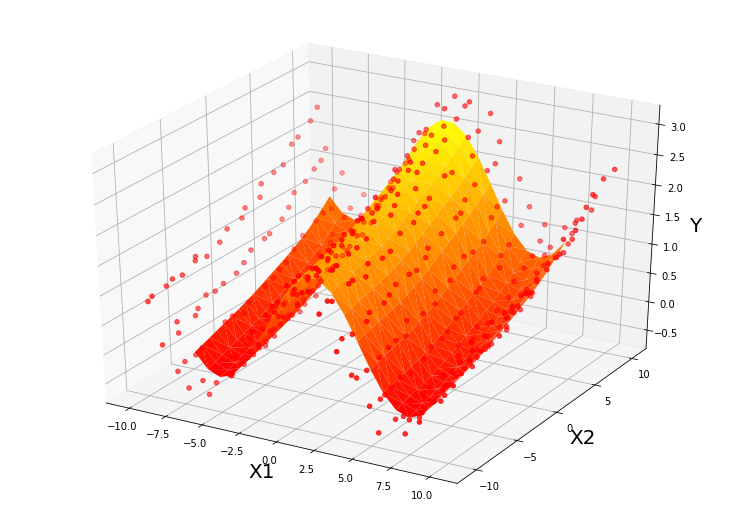

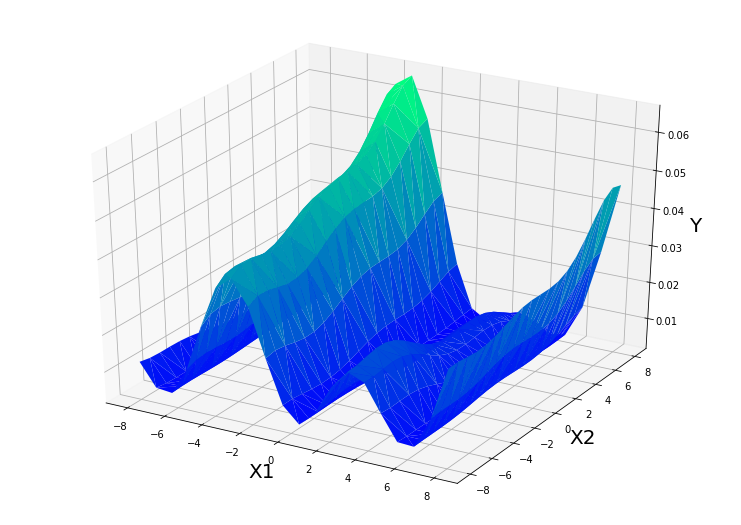

In [44]:
plot_gp_pred(predictions['var'], X, save_name='gp_pred_var')

plot_gp_var(standard_dev['var']**2, X, save_name='gp_pred_var')

### Scikit-Learn Gaussian Process Algorithm

In [45]:

# Their GP
kernel = C() * RBF() + WhiteKernel()
sk_gp_model = GaussianProcessRegressor(kernel=kernel)
sk_gp_model.fit(X['train'], y['train'])
sk_mean, sk_std = sk_gp_model.predict(X['plot'], return_std=True)

In [46]:
predictions['standard'], standard_dev['standard'] = \
    sk_gp_model.predict(X['plot'], return_std=True)

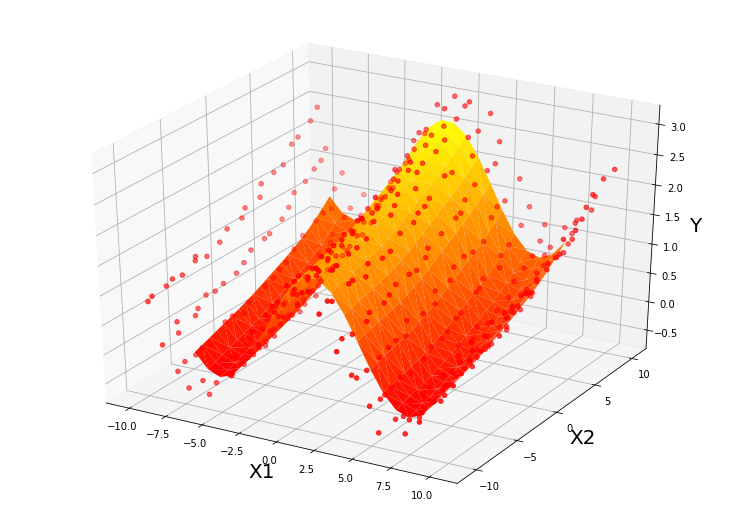

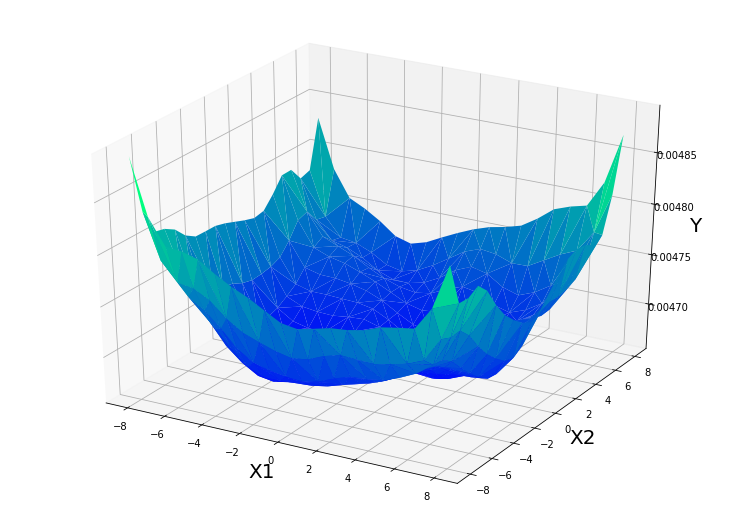

In [47]:
plot_gp_pred(predictions['standard'], X, save_name='gp_pred_stand')

plot_gp_var(standard_dev['standard']**2, X, save_name='gp_var_stand')

### Scikit-Learn Gaussian Process Algorithm (Heteroscedastic Noise Model)

In [48]:
# Their GP
prototypes = KMeans(n_clusters=10).fit(X['train']).cluster_centers_
kernel = C() * RBF() + HeteroscedasticKernel.construct(prototypes)
skh_gp_model = GaussianProcessRegressor(kernel=kernel)
skh_gp_model.fit(X['train'], y['train'])
skh_mean, skh_std = skh_gp_model.predict(X['plot'], return_std=True)

In [49]:
predictions['hetero'], standard_dev['hetero'] = \
    skh_gp_model.predict(X['plot'], return_std=True)

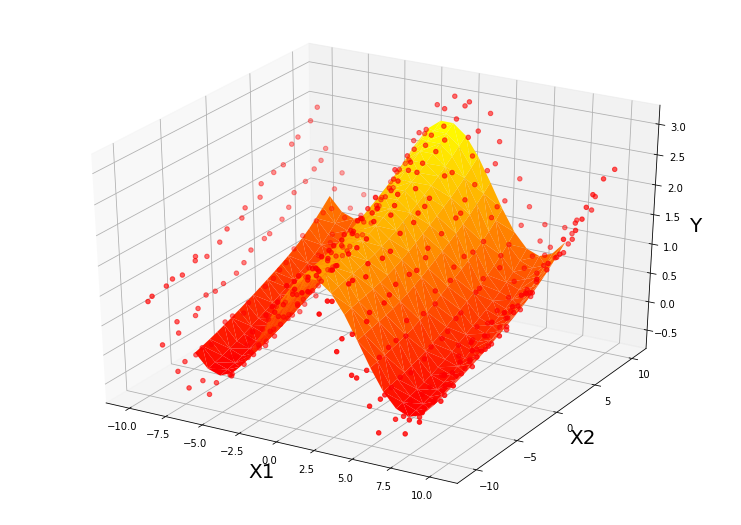

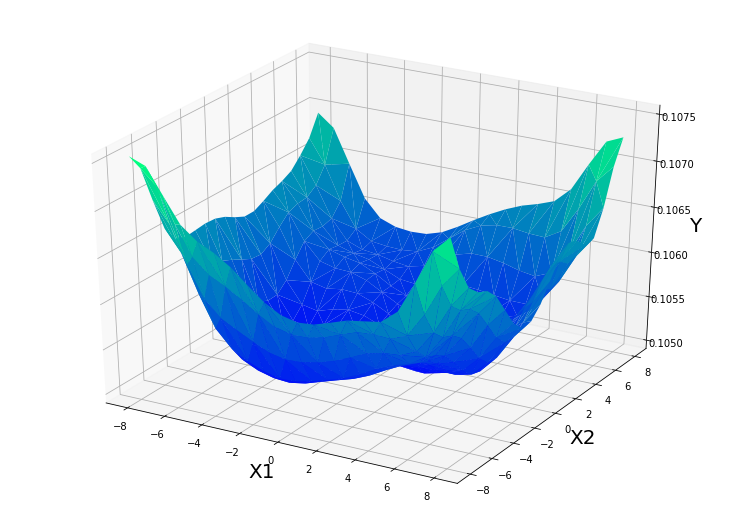

In [50]:
plot_gp_pred(predictions['hetero'], X, save_name='gp_pred_hetero')

plot_gp_var(standard_dev['hetero']**2, X, save_name='gp_var_hetero')

### Error Propagation (Approximate Integral)

In [51]:
gp_errmodel = ErrorHermiteGauss(x_error=x_error)
gp_errmodel.fit(X['train'], y['train']);

In [52]:
predictions['error'], standard_dev['error'] = \
    gp_errmodel.predict(X['plot'], return_std=True)

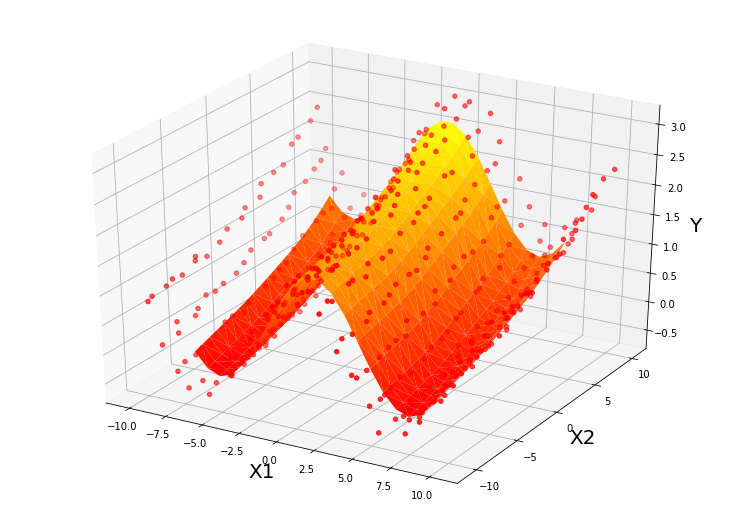

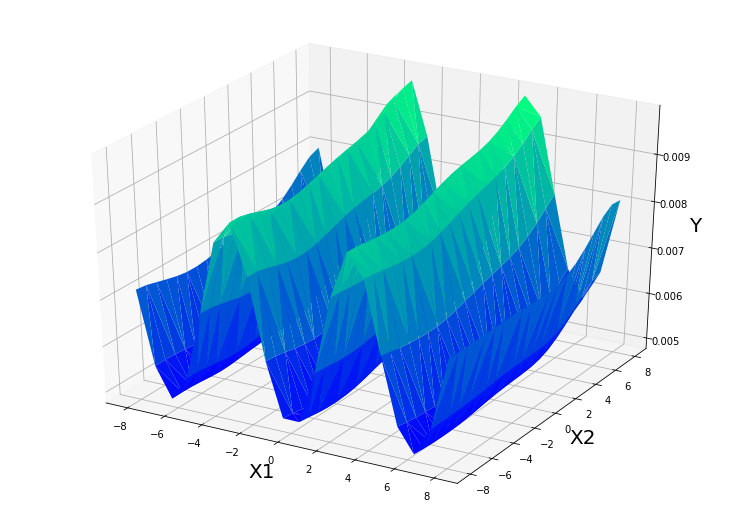

In [53]:
plot_gp_pred(predictions['error'], X, save_name='gp_pred_approx')

plot_gp_var(standard_dev['error']**2, X, save_name='gp_var_approx')

## Empirical Variance

In [64]:
Models = [
    sk_gp_model,
    mygp_clf,
    skh_gp_model
]

In [65]:
def empirical_variance_exp(models, X, error_params, x_error=None, 
                           n_points=1000, n_trials=100):
    
    rng = np.random.RandomState(None)
    x = X['plot']
    f = error_params['f']
    sigmay = error_params['y']
    if x_error is None:
        x_error = error_params['x']
    
    mae_score = {
        'simple': list(),
        'var': list(),
        'approx': list()
    }

    mse_score = {
        'simple': list(),
        'var': list(),
        'approx': list()
    }

    abs_error = {
        'simple': list(),
        'var': list(),
        'approx': list()
    }
    squared_error = {
        'simple': list(),
        'var': list(),
        'approx': list()
    }
    
    x = np.linspace(-10, 10, n_points)
    
    # Testing set (noise-less)
    ytest = f(x)
    ytest += sigmay * rng.randn(n_points)
    ytest = ytest[:, np.newaxis]
    batch_size = 20
    n_jobs = 10
    

    for itrial in range(n_trials):
        if itrial % 100 == 0:
            print('Trial: {}'.format(itrial + 1))

        # Generate x samples with random error
        xtest = x + x_error * rng.randn(n_points)
        xtest = xtest[:, np.newaxis]
        
        #---------------
        # MODEL I
        #---------------
        mean = models[0].predict(xtest)
        
        abs_error['simple'].append(np.abs(mean.squeeze() - ytest.squeeze()))
        squared_error['simple'].append((mean.squeeze() - ytest.squeeze())**2)  
        mae_score['simple'].append(mean_absolute_error(mean.squeeze(), ytest.squeeze()))
        mse_score['simple'].append(mean_squared_error(mean.squeeze(), ytest.squeeze()))
        #---------------
        # MODEL II
        #---------------
        mean = models[0].predict(xtest)
        
        abs_error['var'].append(np.abs(mean.squeeze() - ytest.squeeze()))
        squared_error['var'].append((mean.squeeze() - ytest.squeeze())**2)  
        mae_score['var'].append(mean_absolute_error(mean.squeeze(), ytest.squeeze()))
        mse_score['var'].append(mean_squared_error(mean.squeeze(), ytest.squeeze()))
#         #---------------
#         # MODEL III
#         #---------------
#         mean = models[0].predict(xtest)
        
#         abs_error['hetero'].append(np.abs(mean.squeeze() - ytest.squeeze()))
#         squared_error['hetero'].append((mean.squeeze() - ytest.squeeze())**2)  
#         mae_score['hetero'].append(mean_absolute_error(mean.squeeze(), ytest.squeeze()))
#         mse_score['hetero'].append(mean_squared_error(mean.squeeze(), ytest.squeeze()))
        #---------------
        # MODEL I
        #---------------
        mean = models[0].predict(xtest)
        
        abs_error['approx'].append(np.abs(mean.squeeze() - ytest.squeeze()))
        squared_error['approx'].append((mean.squeeze() - ytest.squeeze())**2)  
        mae_score['approx'].append(mean_absolute_error(mean.squeeze(), ytest.squeeze()))
        mse_score['approx'].append(mean_squared_error(mean.squeeze(), ytest.squeeze()))
    
    # Convert to arrays
    abs_error['simple'] = np.array(abs_error['simple'])
    squared_error['simple'] = np.array(squared_error['simple'])
    mae_score['simple'] = np.array(mae_score['simple'])
    mse_score['simple'] = np.array(mse_score['simple'])

    abs_error['var'] = np.array(abs_error['var'])
    squared_error['exact'] = np.array(squared_error['var'])
    mae_score['var'] =np.array(mae_score['var'])
    mse_score['var'] = np.array(mse_score['var'])

#     abs_error['hetero'] = np.array(abs_error['hetero'])
#     squared_error['hetero'] = np.array(squared_error['hetero'])
#     mae_score['hetero'] = np.array(mae_score['hetero'])
#     mse_score['hetero'] = np.array(mse_score['hetero'])

    abs_error['approx'] = np.array(abs_error['approx'])
    squared_error['approx'] = np.array(squared_error['approx'])
    mae_score['approx'] = np.array(mae_score['approx'])
    mse_score['approx'] = np.array(mse_score['approx'])
    
    
        
    return abs_error, squared_error, mae_score, mse_score

In [66]:
%%time 

abs_error, squared_error, mae_score, mse_score = \
    empirical_variance_exp(Models, X, error_params, n_trials=100)

IndexError: too many indices for array

In [426]:
avg_abs_error = dict()
avg_squared_error = dict()
avg_mae_score = dict()
avg_mse_score = dict()


avg_abs_error['simple'] = np.mean(np.array(abs_error['simple']).squeeze(), axis=0)
avg_squared_error['simple'] = np.mean(np.array(squared_error['simple']).squeeze(), axis=0)
avg_mae_score['simple'] = np.mean(np.array(mae_score['simple']))
avg_mse_score['simple'] = np.mean(np.array(mse_score['simple']))

avg_abs_error['var'] = np.mean(np.array(abs_error['var']).squeeze(), axis=0)
avg_squared_error['var'] = np.mean(np.array(squared_error['var']).squeeze(), axis=0)
avg_mae_score['var'] = np.mean(np.array(mae_score['var']))
avg_mse_score['var'] = np.mean(np.array(mse_score['var']))

avg_abs_error['hetero'] = np.mean(np.array(abs_error['hetero']).squeeze(), axis=0)
avg_squared_error['hetero'] = np.mean(np.array(squared_error['hetero']).squeeze(), axis=0)
avg_mae_score['hetero'] = np.mean(np.array(mae_score['hetero']))
avg_mse_score['hetero'] = np.mean(np.array(mse_score['hetero']))

                       
avg_abs_error['approx'] = np.mean(np.array(abs_error['approx']).squeeze(), axis=0)
avg_squared_error['approx'] = np.mean(np.array(squared_error['approx']).squeeze(), axis=0)
avg_mae_score['approx'] = np.mean(np.array(mae_score['approx']))
avg_mse_score['approx'] = np.mean(np.array(mse_score['approx']))

### Plotting the Empirical Variance

#### Standard GP

In [430]:
def plot_empirical_error(model, squared_error, save_name=None):
    
    x = np.linspace(-10, 10, 1000)
    
    fig, ax = plt.subplots()

    
    pred, std = model.predict(x[:, np.newaxis], return_std=True)
    
    for sq_err in squared_error:
        ax.scatter(x, sq_err, s=0.05, color='k')
        
    ax.plot(x, std**2, linewidth=4, color='r', label='Predictive Variance')
    ax.legend(fontsize=14)
    ax.grid(True)
    plt.show()
    
    if save_name is not None:
        fig.savefig(fig_save + save_name + '.png', bbox_inhces='tight',
                    dpi=100, transparent=True, frameon=None)
    
    return None

In [431]:
def plot_avgempirical_error(model, avg_squared_error, save_name=None):
    
    x = np.linspace(-10, 10, 1000)
    
    pred, std = model.predict(x[:, np.newaxis], return_std=True)
    
    squared_error_line = interpolate.interp1d(x, avg_squared_error, kind='slinear')(x)

    fig, ax = plt.subplots()

    ax.plot(x, squared_error_line, linewidth=2, color='k', label='Average Squared Error')
    ax.plot(x, std**2, linewidth=4, color='r', label='Predictive Variance')
    ax.legend(fontsize=10)
    ax.grid(True)
    plt.show()
    
    if save_name is not None:
        fig.savefig(fig_save + save_name + '.png', bbox_inhces='tight',
                    dpi=100, transparent=True, frameon=None)
    
    return None

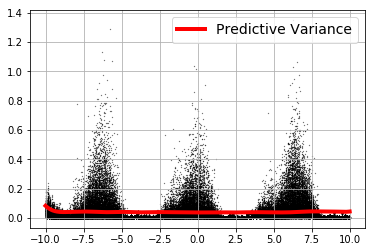

In [432]:
plot_empirical_error(sk_gp_model, squared_error['simple'], 'gp_em_stand')

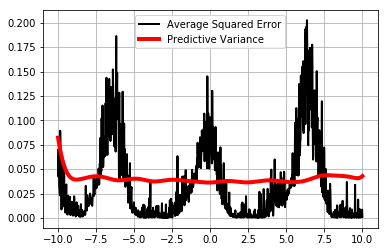

In [434]:
plot_avgempirical_error(sk_gp_model, avg_squared_error['simple'], 'gp_avg_em_stand')

#### GP with Custom Variance

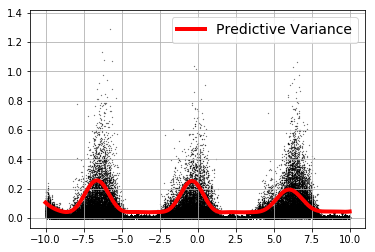

In [440]:
plot_empirical_error(mygp_clf, squared_error['var'], 'gp_em_var')

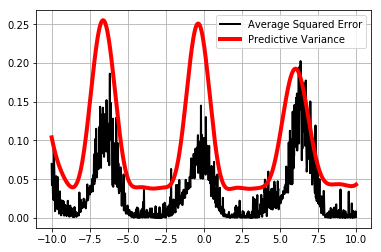

In [441]:
plot_avgempirical_error(mygp_clf, avg_squared_error['var'], 'gp_avg_em_var')

#### Heteroscedastic Model

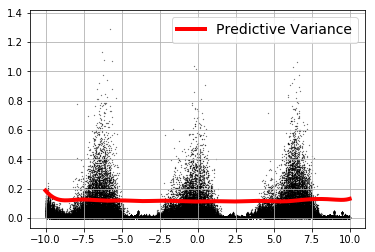

In [442]:
plot_empirical_error(skh_gp_model, squared_error['hetero'], 'gp_em_hetero')

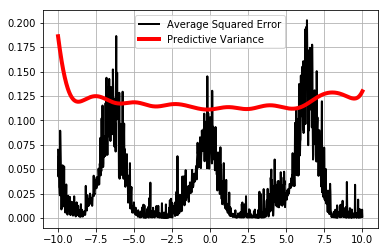

In [443]:
plot_avgempirical_error(skh_gp_model, avg_squared_error['hetero'], 'gp_avg_em_hetero')

#### Approximate Uncertainty

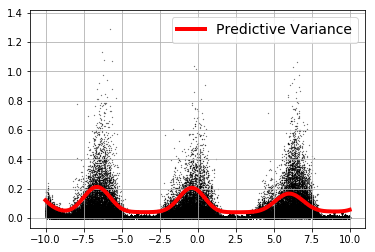

In [444]:
plot_empirical_error(gp_errmodel, squared_error['approx'], 'gp_em_approx')

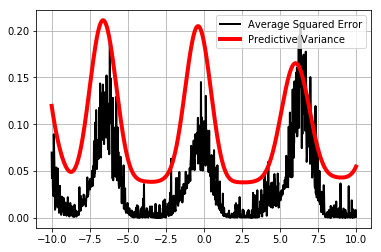

In [445]:
plot_avgempirical_error(gp_errmodel, avg_squared_error['approx'], 'gp_avg_em_approx')

### Average Empirical Variance

(1000,) (1000,)


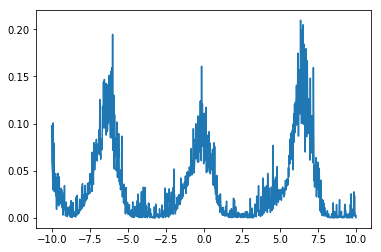

In [233]:
squared_error_line = interpolate.interp1d(x, avg_squared_error['simple'], kind='quadratic')(x)

fig, ax = plt.subplots()
print(x.shape, squared_error_line.shape)
ax.plot(x, squared_error_line)
ax.plot(x, )
plt.show()